The purpose of this notebook is to find solutions of the Lane-Emden equation and then use them to create physical models of stars.

First, we must import the necessary files.

In [1]:
from scipy.integrate import odeint
from scipy.optimize import root_scalar
import numpy as np
import matplotlib.pyplot as plt

Set Newton's constant and the Solar mass in cgs units.

In [2]:
G = 6.6743e-8
M_sol = 1.9891e33

Now we define the Lane-Emden equation as two first order derivatives.  Also add a tiny amount to the denominator of one term to avoid overflows and take the absolute value of $\theta$ in taking powers because this is a problem for some n values.  In our treatment, where we are only considering physically relevant solutions (with $\theta \geq 0$), this last point is only an issue near the root when we are root finding.  Near the root, the $\theta^n$ term contributes negligibly to the derivative.

In [3]:
def lane_emden(y, x, n):
    theta, dtheta = y
    dydx = [dtheta, -2. * dtheta / (x + 1.e-300) - np.power(np.abs(theta), n)]
    return dydx

Now we set up the root function to find the independent variable that gives the solution to the Lane-Emden equation equal to the input value theta.

In [4]:
def f(x, theta, n):
    assert(n > 0 and n < 5)
    y0 = [1., 0.]
    xsol = np.linspace(0, x, 101)
    sol = odeint(lane_emden, y0, xsol, args=(n,))
    return sol[sol.shape[0]-1, 0] - theta

Now we choose n.

In [5]:
n = 3

Now find the root for $\theta = 0$.

In [6]:
theta = 0
sol = root_scalar(f, x0 = 1, x1 = 2, args=(theta, n,))

With the root, create the full solution.

In [7]:
x = np.linspace(0, sol.root, 101)
msol = odeint(lane_emden, [1., 0.], x, args=(n,))

Retrieve the first zero and derivative.

In [8]:
xsi1 = sol.root
dxsi1 = msol[msol.shape[0]-1, 1]

print("The full root xi_1 = {:f} and the derivative at the root dxi_1 / dtheta = {:f}".format(xsi1, dxsi1))

The full root xi_1 = 6.896848 and the derivative at the root dxi_1 / dtheta = -0.042430


Plot the solution to the Lane-Emden equation over the relevant range.

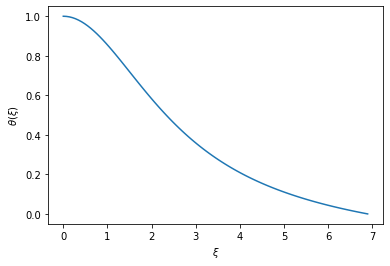

In [9]:
plt.plot(x, msol[:,0])
plt.xlabel("$\\xi$")
plt.ylabel("$\\theta(\\xi)$")
plt.show()

Create a physical polytrope.  Choose a central density and a total mass.

In [10]:
rho_c = 1.e10
M = 1.4 * M_sol

Now compute the pressure coefficient from the input stellar parameters.

In [11]:
K = (4 * np.pi * G / (n + 1)) * np.power((-M / (4 * np.pi * np.power(rho_c, (3.-n)/(2.*n))*xsi1**2*dxsi1)), 2./3.)
P_c = K * np.power(rho_c, 1 + 1./n)
print("The central pressure is {:e} dynes / cm^2".format(P_c))

The central pressure is 1.035836e+28 dynes / cm^2


Now compute the length scale and the stellar radius.

In [12]:
a = np.sqrt(((n+1) * K * np.power(rho_c, (1. - n)/n)) / (4 * np.pi * G))
print("The length scale is {:f} km".format(a / 1.e6))
print("The stellar radius is {:f} km".format(a * xsi1 / 1.e6))

The length scale is 22.226324 km
The stellar radius is 153.291583 km


Compute the enclosed mass coordinate.

In [13]:
Mr = -4 * np.pi * a**3 * rho_c * x**2 * msol[:,1]

Graph the density as a function of the enclosed mass.

Text(0, 0.5, '$\\rho$ (g/cc)')

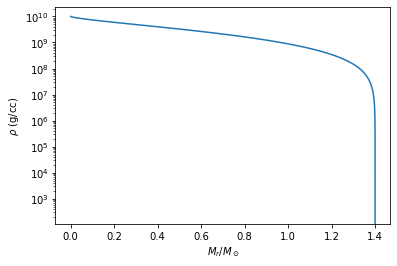

In [14]:
plt.plot(Mr / M_sol, rho_c * np.power(msol[:,0], n))
plt.yscale('log')
plt.xlabel('$M_r / M_\\odot$')
plt.ylabel('$\\rho$ (g/cc)')

Plot the radial coordinate as a function of enclosed mass.

Text(0, 0.5, 'r (km)')

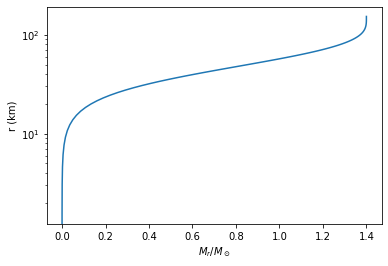

In [15]:
plt.plot(Mr / M_sol, a * x / 1.e6)
plt.yscale('log')
plt.xlabel('$M_r / M_\\odot$')
plt.ylabel('r (km)')

Now plot the pressure as a function of enclosed mass.  Use the absolute value of the solution to avoid problems near surface.

(10000000000.0, 1.0358357142235054e+29)

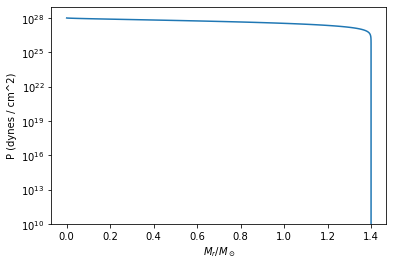

In [16]:
p = K * np.power(rho_c * np.abs(msol[:,0]), 1. + 1. / n)
plt.plot(Mr / M_sol, p)
plt.yscale('log')
plt.xlabel('$M_r / M_\\odot$')
plt.ylabel('P (dynes / cm^2)')
plt.ylim([1.e10, 10 * p[0]])

Define a set of densities.

In [17]:
rhos = [1.e10, 9.e9, 8.e9, 7.e9, 6.e9, 5.e9, 4.e9, 3.e9, 2.e9, 1.e9, 1.e8, 1.e7, 1.e6, 1.e5, 1.e4, 0]

Define a routine to compute the mass from an input density $\rho$.  Do this as follows.   $\theta = (\rho / \rho_c)^{1/n}$, so find the $\xi$ that gives this $\theta$ for the given $n$ and $\rho_c$.  Then compute $d\theta / d\xi$ at that $\xi$.  Finally, compute $M(\xi) = -4 \pi a^3 \rho_c \xi^2 d\theta / d\xi$.

In [18]:
def m_from_rho(n, rho_c, a, rho_p):
    assert(rho_p <= rho_c and rho_p >= 0)
    theta = np.power(rho_p / rho_c, 1. / n)
    sol = root_scalar(f, x0 = 1, x1 = 2, args=(theta, n,))
    sol_p = odeint(lane_emden, [1., 0.], [0, sol.root], args=(n,))
    return -4 * np.pi * a**3 * rho_c * sol.root**2 * sol_p[1,1]

Compute the masses from the range of densities.

In [19]:
Ms = [0]
for i in range(1, len(rhos)):
    Ms.append(m_from_rho(n, rho_c, a, (rhos[i] + rhos[i-1])/2))

Compute the mass shells for the given densities.

In [20]:
for i in range(0, len(rhos)-1):
    print("{:e}".format(rhos[i]), "{:e}".format((Ms[i+1] - Ms[i])/ M_sol))

1.000000e+10 7.443430e-03
9.000000e+09 3.271912e-02
8.000000e+09 4.985830e-02
7.000000e+09 6.592197e-02
6.000000e+09 8.295576e-02
5.000000e+09 1.024418e-01
4.000000e+09 1.263443e-01
3.000000e+09 1.582219e-01
2.000000e+09 2.064828e-01
1.000000e+09 2.826767e-01
1.000000e+08 2.433534e-01
1.000000e+07 3.761277e-02
1.000000e+06 3.692936e-03
1.000000e+05 2.591848e-04
1.000000e+04 1.490197e-05
